In [2]:
#%load_ext autoreload
#%autoreload 2

import os
import numpy as np 
from multiprocessing import Pool
import time 
import random
import IPython.display as ipd
import pyaudio
import sys
import librosa
import librosa.display
from tqdm import tqdm
from matplotlib import pyplot as plt
sys.path.append('../../')

import pdb
#import utils.audio as a
#import utils.plots as plots
import utils as utils

### Load audio files into dataset

In [3]:
# load (fe)male audio sequences without alpha, beta 
PATH = '../../datasets/freesound.org/wav/'
SR = 22050 

dataset = []

files = os.listdir(PATH)

for f in tqdm(files):
    if f.split('.')[-1] != 'wav':
        continue
    #pdb.set_trace()
    audio, sr = utils.audio.loadAudio(PATH + f, sr=SR)
    dataset.append(audio)

100%|██████████| 383/383 [00:00<00:00, 621.62it/s]


In [4]:
dataset = np.array(dataset)
len(dataset[1])

101485

In [5]:
# read data
data = utils.misc.slidingWindow(dataset, int(SR*1), int(SR*1))

In [12]:
# create chunks
dataset_chunks = []
for chunk in dataset:
    #pdb.set_trace()
    w = utils.misc.slidingWindow(chunk, int(SR*1), int(SR*1))
    if len(w) != 0:
        dataset_chunks.append(w)


In [13]:
# concatenate chunks
chunk_seq = np.array(dataset_chunks)
print(list(filter(lambda x: len(x)==0, chunk_seq)))
chunks = np.concatenate((chunk_seq[:]), axis=0)
chunks.shape

[]


(3075, 22050)

In [14]:
dataset_chunks[0].shape
display(ipd.Audio(dataset_chunks[1][0], rate=SR))
display(ipd.Audio(dataset_chunks[1][1], rate=SR))
display(ipd.Audio(dataset_chunks[1][2], rate=SR))
display(ipd.Audio(dataset_chunks[1][3], rate=SR))
display(ipd.Audio(dataset_chunks[1][4], rate=SR))
display(ipd.Audio(dataset_chunks[1][5], rate=SR))
display(ipd.Audio(dataset_chunks[1][6], rate=SR))

display(ipd.Audio(dataset_chunks[1][:].reshape(-1), rate=22050))




IndexError: index 4 is out of bounds for axis 0 with size 4

In [16]:
from skimage.transform import resize
num_points = 1000
num_feats = 6
num_chunks = chunks.shape[0]
hop_length = 256
#X = np.zeros((num_chunks, 44*num_feats))
X = []
for i in tqdm(range(num_chunks)):
    #pdb.set_trace()
     # mfcc
    feat = librosa.feature.mfcc(y=chunks[i, :], sr=SR, n_mfcc=num_feats).flatten() # 13x44
    # chroma
    chroma_cq = librosa.feature.chroma_cqt(y=chunks[i, :], sr=SR, hop_length=hop_length).flatten() #12x44
    # RMS mag spec
    rms = librosa.feature.rms(y=chunks[i, :]).flatten() #1x44
    # Spectral centroid
    cent = librosa.feature.spectral_centroid(y=chunks[i, :], sr=SR).flatten()#1x44
    # Spectral bandwidth
    band = librosa.feature.spectral_bandwidth(y=chunks[i, :], sr=SR).flatten()#1x44
    # Spectral flatness
    flat = librosa.feature.spectral_flatness(y=chunks[i, :]).flatten()#1x44
    # spectral rolloff
    rolloff = librosa.feature.spectral_rolloff(y=chunks[i, :], sr=SR).flatten()#1x44
    # zero crossing rate 
    zcross = librosa.feature.zero_crossing_rate(chunks[i, :]).flatten()#1x44
    # Spectral contrast
    S = np.abs(librosa.stft(chunks[i, :]))
    spec_contrast = librosa.feature.spectral_contrast(S=S, sr=SR).flatten() #7x44
    # Tonnetz
    y = librosa.effects.harmonic(chunks[i, :])
    tonnetz = librosa.feature.tonnetz(y=y, sr=SR).flatten() #6x44
    # local and global tempogram    
    oenv = librosa.onset.onset_strength(y=chunks[i, :], sr=SR, hop_length=hop_length)
    tempogram = resize(librosa.feature.tempogram(onset_envelope=oenv, sr=SR, hop_length=hop_length), (32, 44)) #32x44
    # Compute global onset autocorrelation
    ac_global = librosa.autocorrelate(oenv, max_size=tempogram.shape[0])
    ac_global = librosa.util.normalize(ac_global)
    # Estimate the global tempo for display purposes
    tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr, hop_length=hop_length)[0]
    #pdb.set
    X.append(np.concatenate((feat, chroma_cq, rms, cent, band, flat, rolloff, zcross, spec_contrast, tonnetz, tempogram.flatten(), tempo.reshape(1))))
    #X.append(np.array(librosa.feature.mfcc(y=chunks[i, :], sr=SR, n_mfcc=num_feats).flatten()))

  9%|▊         | 264/3075 [01:04<11:28,  4.08it/s]


KeyboardInterrupt: 

In [5]:
num_points = 1000
num_feats = 6
num_chunks = chunks.shape[0]
#X = np.zeros((num_chunks, 44*num_feats))
X = []
for i in tqdm(range(num_chunks)):
    #pdb.set_trace()
    #X[i, :] = librosa.feature.mfcc(y=chunks[i, :], sr=SR, n_mfcc=num_feats).flatten()
    X.append(np.array(librosa.feature.mfcc(y=chunks[i, :], sr=SR, n_mfcc=num_feats).flatten()))

100%|██████████| 10641/10641 [00:28<00:00, 377.34it/s]


In [6]:
chunk_feat = []
chunk_feat_sub = []
for i in tqdm(range(chunk_seq.shape[0])):
    chunk_feat_sub = []
    for j in range(chunk_seq[i].shape[0]):
        chunk_feat_sub.append(librosa.feature.mfcc(y=chunk_seq[i][j], sr=SR, n_mfcc=num_feats))
    chunk_feat.append(chunk_feat_sub)

100%|██████████| 382/382 [00:27<00:00, 13.83it/s]


In [46]:
np.array(X).shape
#len(chunk_feat[1])


(10641, 78)

In [136]:
X1 = [[0.5], [1.0], [-1.0], [0.42], [0.24]]
X2 = [[2.4], [4.2], [0.5], [-0.24]]
X3 = np.concatenate([X1, X2])
lengths = [len(X1), len(X2)]
print(len(lengths))
print(X3.shape)

2
(9, 1)


In [7]:
len_vec = np.array([len(chunk_feat[x]) for x in range(len(chunk_feat))])
print(len(len_vec))

382


In [54]:
idx_zero = list(filter(lambda x: x==0, len_vec))
X = np.array(X)
idx_zero, _ = np.where(len_vec==0)
np.sum(len_vec[:idx_zero[0]])

ValueError: not enough values to unpack (expected 2, got 1)

In [49]:
print(np.array(X).shape)

(10641, 78)


In [96]:
import numpy as np
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(X)

x_pca = PCA(n_components=2).fit_transform(X_scaled)
np.random.seed(42)
#remodel = hmm.GaussianHMM(n_components=3, covariance_type="diagonal", n_iter=100)
remodel = hmm.GaussianHMM(n_components=5, verbose=True, covariance_type="full", n_iter=20)
remodel.fit(np.array(x_pca), len_vec)

         1      -20126.2881             +nan
         2      -14089.0759       +6037.2122
         3      -12190.0328       +1899.0431
         4      -10557.2819       +1632.7509
         5       -9516.4095       +1040.8724
         6       -8954.5563        +561.8532
         7       -8714.5512        +240.0051
         8       -8623.9234         +90.6278
         9       -8574.0255         +49.8979
        10       -8530.3226         +43.7029
        11       -8498.9141         +31.4086
        12       -8475.0988         +23.8153
        13       -8457.4210         +17.6778
        14       -8442.1582         +15.2627
        15       -8427.9888         +14.1695
        16       -8416.0124         +11.9764
        17       -8407.8787          +8.1337
        18       -8402.6889          +5.1898
        19       -8398.6787          +4.0102
        20       -8395.3615          +3.3172


GaussianHMM(covariance_type='full', n_components=5, n_iter=20, verbose=True)

In [12]:
from sklearn.decomposition import PCA

x_pca = PCA(n_components=2).fit(X_scaled)


In [23]:
# summation of PCAs
np.sum(x_pca.explained_variance_ratio_)

AttributeError: 'numpy.ndarray' object has no attribute 'explained_variance_ratio_'

In [61]:

Z2 = remodel.predict(np.array(X)[len_vec[0]:len_vec[1]])
ll = remodel.score(np.array(X)[len_vec[0]:len_vec[1]])

print(Z2, ll)

[1 1 1 1 1 1 0 4] -3100.472438865198


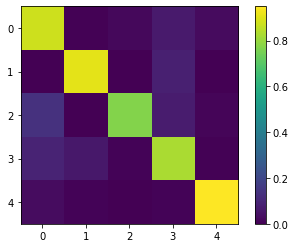

In [98]:
plt.imshow(remodel.transmat_)
plt.colorbar()

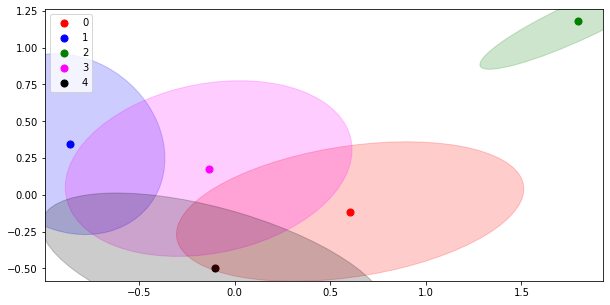

In [97]:
import matplotlib as mpl
fig1 = plt.figure(figsize=[10, 5])
ax1 = fig1.add_subplot(111)
colors = ['red', 'blue', 'green', 'magenta', 'black', 'darkgreen', 'orange', 'crimson', 'grey']
for i, (m, c) in enumerate(zip(remodel.means_, remodel.covars_)):
    ax1.scatter(m[0], m[1], s=50, c=colors[i], label=str(i))
    plot_ellipse(ax1, m, c, colors[i])
plt.legend()
plt.show()

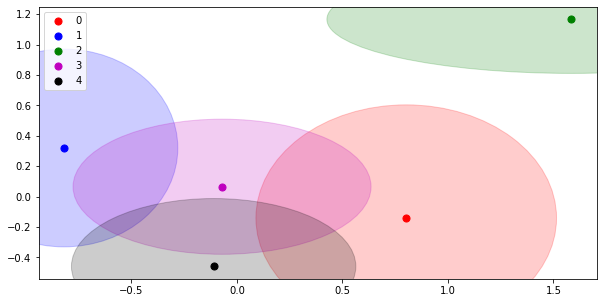

In [47]:
import matplotlib as mpl
fig1 = plt.figure(figsize=[10, 5])
ax1 = fig1.add_subplot(111)
colors = ['r', 'b', 'g', 'm', 'k', 'c']
for i, (m, c) in enumerate(zip(remodel.means_, remodel.covars_)):
    ax1.scatter(m[0], m[1], s=50, c=colors[i], label=str(i))
    plot_ellipse(ax1, m, c, colors[i])
plt.legend()
plt.show()

In [70]:
i=0
samples_list = []
states_list = []
while i < 10:
    samples, states = remodel.sample(7)
    samples_list.append(samples)
    states_list.append(states)
    i += 1
#remodel.sample(7)
print(len(synthesized[0][1]))

7


In [78]:
len(samples_list[1][0]), len(states_list[1])


(78, 7)

In [12]:
from hmmlearn.hmm import GaussianHMM
if n_states is None:
    components = [5, 6, 8, 10, 12]
    hmms = [GaussianHMM(n_components=c) for c in components]
    map(lambda g: g.fit(per_data, per_lens), hmms)
    scores = map(lambda g: aic(g, per_data, per_lens), hmms)
    max_score, self.hmm = sorted(zip(scores, hmms))[0]
else:
    self.hmm = GaussianHMM(n_components=n_states)
    self.hmm.fit(per_data, per_lens)
ll = self.hmm.score(per_data, per_lens)
aic_ = aic(self.hmm, per_data, per_lens)
print "Goal HMM n_components", self.hmm.n_components, "Log likelihood", ll, "AIC", aic_

(3075,)

In [20]:
def plot_ellipse(ax, pos, cov, color):
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    width, height = 4 * np.sqrt(np.abs(vals))
    time.sleep(0.1)
    ellip = mpl.patches.Ellipse(xy=pos, width=width, height=height, angle=theta, lw=1, fill=True, alpha=0.2, color=color)
    ax.add_artist(ellip)

In [ ]:
G = pgv.AGraph(strict=False, directed=True, dpi=300)
T = goal_model.hmm.transmat_
visited = []
start = None
for i in range(T.shape[0]):
    for j in range(T.shape[1]):
        t = round(T[i,j], 2)
        if t > 1e-10 and (i,j) not in visited:
            print(t*10)
            s = np.clip(7*t, 0, 1.5)
            G.add_edge(i, j, arrowsize=s)# label=t)
            visited.append((i,j))
    pi = round(goal_model.hmm.startprob_[i], 2)
    if pi == 1:
        start = i
for s in goal_model.final_states:
    n = G.get_node(s)
    n.attr['color'] = 'green'

In [10]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=64, verbose=2).fit(pca_X)
labels = gmm.predict(pca_X)

Initialization 0
Initialization converged: True	 time lapse 506.00775s	 ll 18808.46868


(3075,)


(array([322., 270., 375., 319., 192., 193., 434., 458., 260., 252.]),
 array([ 0. ,  6.3, 12.6, 18.9, 25.2, 31.5, 37.8, 44.1, 50.4, 56.7, 63. ]),
 <BarContainer object of 10 artists>)

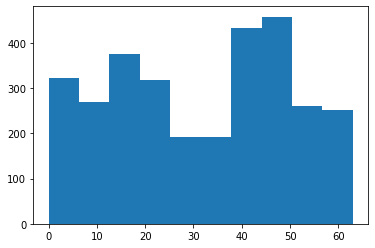

In [11]:
print(labels.shape)
plt.hist(labels)
#print(labels[1000:2000])

In [12]:
#%matplotlib inline
#pca_scaled_X = StandardScaler().fit_transform(pca_X)
pca_scaled_X = pca_X
plot_X = PCA(n_components=3).fit_transform(pca_scaled_X)

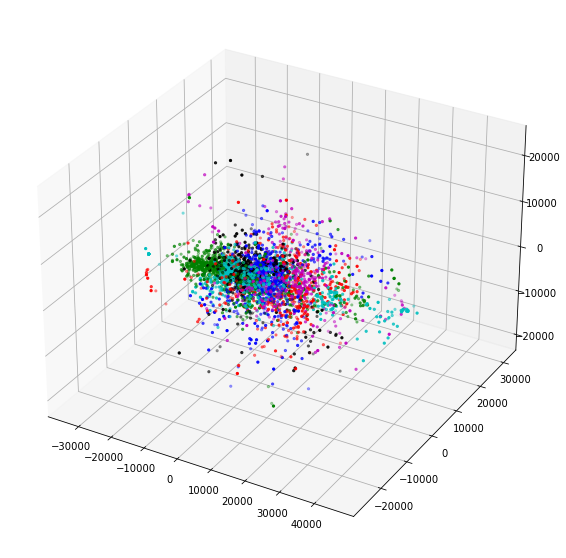

In [16]:
%matplotlib inline
colors = ['r', 'b', 'g', 'm', 'k', 'c']
fig1 = plt.figure(figsize=[20, 10])
ax1 = fig1.add_subplot(111, projection='3d')
for i in range(64):
    ax1.scatter(plot_X[labels==i, 0], plot_X[labels==i, 1], plot_X[labels==i, 2], c=colors[i%6], s=5.);
plt.show()

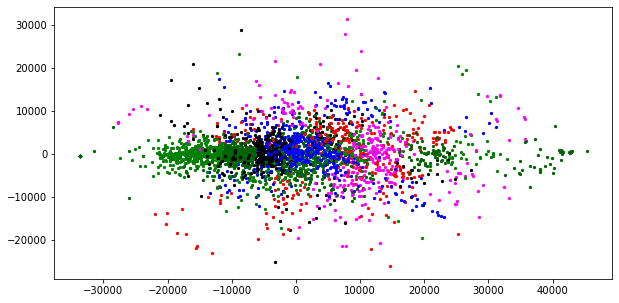

In [17]:
#%matplotlib inline
plot_X2 = PCA(n_components=2).fit_transform(pca_scaled_X)
colors = ['red', 'blue', 'green', 'magenta', 'black', 'darkgreen', 'orange', 'crimson', 'grey'] #'cyan',
fig2 = plt.figure(figsize=[10, 5])
ax2 = fig2.add_subplot(111)
for i in range(64):.-+
    ////////////////////////////////////////////////////////////////////
    ax2.scatter(plot_X2[labels==i, 0], plot_X2[labels==i, 1], c=colors[i%6], s=5);
plt.show()
#plt.savefig('mfcc_spectral_features.png')

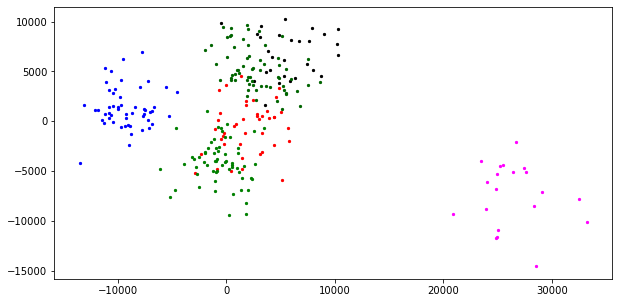

In [15]:
#%matplotlib inline
plot_X2 = PCA(n_components=2).fit_transform(pca_X)
colors = ['red', 'blue', 'green', 'magenta', 'black', 'darkgreen', 'orange', 'crimson', 'grey'] #'cyan',
fig2 = plt.figure(figsize=[10, 5])
ax2 = fig2.add_subplot(111)
for i in range(6):
    ax2.scatter(plot_X2[labels==i, 0], plot_X2[labels==i, 1], c=colors[i], s=5);
plt.show()

In [155]:
target = 0
idx = np.where(labels==target)[0][0]
print(labels[idx])
#i = idx // num_chunks
#j = idx % num_chunks
display(ipd.Audio(chunks[idx, :], rate=SR))

idx = np.where(labels==target)[0][5]
display(ipd.Audio(chunks[idx, :], rate=SR))

idx = np.where(labels==target)[0][10]
display(ipd.Audio(chunks[idx, :], rate=SR))

idx = np.where(labels==target)[0][15]
display(ipd.Audio(chunks[idx, :], rate=SR))

idx = np.where(labels==target)[0][20]
display(ipd.Audio(chunks[idx, :], rate=SR))

idx = np.where(labels==target)[0][30]
display(ipd.Audio(chunks[idx, :], rate=SR))


0


In [149]:
idx = np.where(labels==target)[0][10]
print(labels[idx])
#i = idx // num_chunks
#j = idx % num_chunks
ipd.Audio(chunks[idx, :], rate=SR)

1


In [150]:
idx = np.where(labels==target)[0][20]
print(labels[idx])
#i = idx // num_chunks
#j = idx % num_chunks
ipd.Audio(chunks[idx, :], rate=SR)

1


In [151]:
idx = np.where(labels==target)[0][30]
print(labels[idx])
#i = idx // num_chunks
#j = idx % num_chunks
ipd.Audio(chunks[idx, :], rate=SR)

1
